# Original Dataset: Air Quality in Madrid in 2018

The .csv file shows the air quality parameters (chemicals) measured at each of the stations in Madrid every 24 hours over the course of 4 months (January to April) in 2018. 

We originally planned to use regression on this dataset; however, we found that it was too difficult. There was no one parameter that would address air quality and instead showed the measurements of various chemicals in the air. There was also insuffient data; where many of the stations were missing half the chemicals. The only consistent readings among the chemcials was NO, NO_2, and NO_x. We would have needed to choose one as our target and two as our data, we would not have suffient information for a regression. Also, the presence of certain chemicals does not neccessairly correlate with the presence of other chemicals, so it would not have been a good dataset to choose for a regression classifier.

In [11]:
import csv
import numpy as np
import numpy.linalg as LA
import matplotlib.pyplot as plt
import pandas as pd

with open('madrid_2018.csv', newline='') as csvfile:
    data = list(csv.reader(csvfile))

# creating all data for station 28079004
data = np.array(data)
data = data[1:data.shape[0],0:data.shape[1]]
airq = []
date = []
for i in range(0, data.shape[0]):
    for j in range(0, data.shape[1]):
        if(data[i,-1]=='28079004'):
            if(j==0):
                date.append(data[i,j])
            elif(data[i,j]==''):
                airq.append('0')
            else:
                airq.append(data[i,j])
            
airq = np.array(airq)
date = np.array(date)
airq = np.reshape(airq, (2880,15))

airq = airq.astype(np.float)

pddata = pd.read_csv("madrid_2018.csv")
pddata.head()

,date,BEN,CH4,CO,EBE,NMHC,NO,NO_2,NOx,O_3,PM10,PM25,SO_2,TCH,TOL,station
0,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,29.0,31.0,NaN,NaN,NaN,2.0,NaN,NaN,28079004
1,2018-03-01 01:00:00,0.5,1.39,0.3,0.2,0.02,6.0,40.0,49.0,52.0,5.0,4.0,3.0,1.41,0.8,28079008
2,2018-03-01 01:00:00,0.4,NaN,NaN,0.2,NaN,4.0,41.0,47.0,NaN,NaN,NaN,NaN,NaN,1.1,28079011
3,2018-03-01 01:00:00,NaN,NaN,0.3,NaN,NaN,1.0,35.0,37.0,54.0,NaN,NaN,NaN,NaN,NaN,28079016
4,2018-03-01 01:00:00,NaN,NaN,NaN,NaN,NaN,1.0,27.0,29.0,49.0,NaN,NaN,3.0,NaN,NaN,28079017


# Forecasting Temperature

In [14]:
with open('weatherHistory.csv', newline='') as csvfile:
    predata = list(csv.reader(csvfile))

# processing the csv information into target and data for regression
predata = np.array(predata)
predata = predata[1:predata.shape[0],3:-1]
np.random.shuffle(predata)
target = predata[:,0].astype(float)
data = predata[:,1:6].astype(float)

pddata = pd.read_csv("weatherHistory.csv")
pddata.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Apparent Temperature (C),Humidity,Wind Speed (km/h),Wind Bearing (degrees),Visibility (km),Loud Cover,Pressure (millibars),Daily Summary
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,7.388889,0.89,14.1197,251.0,15.8263,0.0,1015.13,Partly cloudy throughout the day.
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,7.227778,0.86,14.2646,259.0,15.8263,0.0,1015.63,Partly cloudy throughout the day.
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,9.377778,0.89,3.9284,204.0,14.9569,0.0,1015.94,Partly cloudy throughout the day.
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,5.944444,0.83,14.1036,269.0,15.8263,0.0,1016.41,Partly cloudy throughout the day.
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,6.977778,0.83,11.0446,259.0,15.8263,0.0,1016.51,Partly cloudy throughout the day.


We used the temperature (C) column as our target value and used apparent temperature (C), humidity, wind speed (km/h), wind bearing (degrees), and visibility (km) columns as our data parameters.

## Approach 1: Least Squares (using K-fold validation)

For the least sqaures approach, we used the algorithm and implementation discussed in class. The aim of regression is to be able to find a function such that $$y = w^Tb$$. In least squares, we use the following equation to find $\hat{w}$ which is $$\hat{w} = (X^TX)^{-1}y$$ on our training set. We can then use $$y = \hat{w}^Tb$$ to find the predicted values for our test set.

0.8958770119825288
0.9019150108263143
0.9043085354334768
0.89913904063337
0.9053742030703918
The average prediction error from 5-fold CV:  0.9013227603892163


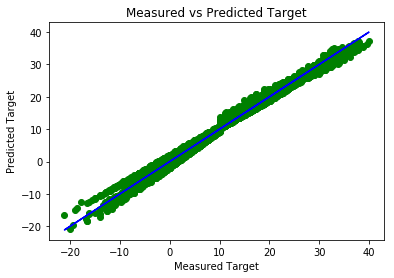

In [15]:
# function to calculate Least Sqaures on training set
def LS(data, labels):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)), np.transpose(data)), labels)
    return w_hat

# function to check errors on test set
def LS_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

# append ones column to our X
X = np.ones((len(data), 6))
for i in range(0, len(data)):
    for j in range(0, 5):
        X[i, j] = data[i, j]

# split our data into test and validation for K fold CV, where K=5
test1 = X[0:19290]
testlab1 = target[0:19290]
train1 = X[19290:96453] 
label1 = target[19290:96453]

test2 = X[19290:38580, :]
testlab2 = target[19290:38580]
train2 = np.concatenate((X[0:19290, :], X[38580:96453, :]))
label2 = np.concatenate((target[0:19290], target[38580:96453]))

test3 = X[38580:57870, :]
testlab3 = target[38580:57870]
train3 = np.concatenate((X[0:38580, :], X[57870:96453, :]))
label3 = np.concatenate((target[0:38580], target[57870:96453]))

test4 = X[57870:77160, :]
testlab4 = target[57870:77160]
train4 = np.concatenate((X[0:57870, :], X[77160:96453, :]))
label4 = np.concatenate((target[0:57870], target[77160:96453]))

test5 = X[77160:96453, :]
testlab5 = target[77160:96453]
train5 = X[0:77160, :]
label5 = target[0:77160]

# train on each set and check error
w1 = LS(train1, label1)
y1, err1 = LS_error(test1, testlab1, w1)
print(err1)

w2 = LS(train2, label2)
y2, err2 = LS_error(test2, testlab2, w2)
print(err2)

w3 = LS(train3, label3)
y3, err3 = LS_error(test3, testlab3, w3)
print(err3)

w4 = LS(train4, label4)
y4, err4 = LS_error(test4, testlab4, w4)
print(err4)

w5 = LS(train5, label5)
y5, err5 = LS_error(test5, testlab5, w5)
print(err5)

# average prediction error for LS
avg = (err1+err2+err3+err4+err5)/5
print("The average prediction error from 5-fold CV: ", avg)

# plot of one of the measured vs predicted target values
plt.scatter(testlab4, y4, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

## Approach 2: Ridge Regression (with K-fold CV)

For the ridge regression approach, we used the algorithm and implementation discussed in class. The aim of regression is to be able to find a function such that $$y = w^Tb$$. In lridge regression, we use the following equation to find $\hat{w}$ which is $$\hat{w} = (X^TX+\lambda I)^{-1}y$$ on our training set. We use K fold CV to find the optimal $\lambda$. We can then use $$y = \hat{w}^Tb$$ to find the predicted values for our test set.

The average prediction error from 5-fold CV:  0.9013913970931414
From index:  3
Thus, the best lambda value: 0.3333333333333333


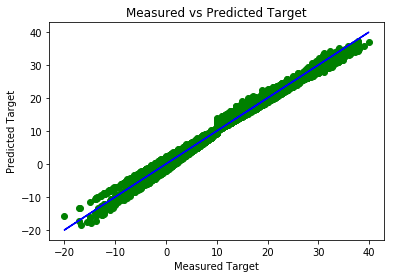

In [19]:
# function to calculate ridge regression on training data
def RR(data, labels, lam):
    w_hat = np.matmul(np.matmul(LA.inv(np.matmul(np.transpose(data), data)+lam*np.identity(data.shape[1])), np.transpose(data)), labels)
    return w_hat

# function to calulcate errors on test data
def RR_error(X, labels, w_hat):
    y_est = np.matmul(X, w_hat)
    error = LA.norm(labels-y_est)**2/X.shape[0]
    return y_est, error

# setting up lambda and errors for the K fold CV
lam = np.linspace(0, 10, num=91)
err1 = np.zeros(91)
err2 = np.zeros(91)
err3 = np.zeros(91)
err4 = np.zeros(91)
err5 = np.zeros(91)
avg = np.zeros(91)

# running K fold CV (where K=5) to find optimal lambda and check average prediction error
for i in range(0, len(lam)):
    w1 = RR(train1, label1, lam[i])
    y1, err1[i] = RR_error(test1, testlab1, w1)

    w2 = RR(train2, label2, lam[i])
    y2, err2[i] = RR_error(test2, testlab2, w2)

    w3 = RR(train3, label3, lam[i])
    y3, err3[i] = RR_error(test3, testlab3, w3)

    w4 = RR(train4, label4, lam[i])
    y4, err4[i] = RR_error(test4, testlab4, w4)

    w5 = RR(train5, label5, lam[i])
    y5, err5[i] = RR_error(test5, testlab5, w5)
    
    avg[i] = (err1[i]+err2[i]+err3[i]+err4[i]+err5[i])/5

# find optimal lambda and report average prediction error
print("The average prediction error from 5-fold CV: ", np.min(avg))
print("From index: ", np.argmin(avg))    
print("Thus, the best lambda value:", lam[np.argmin(avg)])

# plot optimal lambda and prediction for one of the test sets
w = RR(train4, label4, lam[np.argmin(avg)])
y, err = RR_error(test4, testlab4, w)
plt.scatter(testlab4, y, c='g')
plt.plot(testlab4,testlab4, 'b')
plt.title("Measured vs Predicted Target")
plt.xlabel("Measured Target")
plt.ylabel("Predicted Target")
plt.show()

# Regression Trees

Split data into train and test set.

In [26]:
import numpy as np
from sklearn.tree import DecisionTreeRegressor
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split

X_train, X_test, y_train, y_test = train_test_split(data,target,test_size = 0.3, random_state = 0)



(67517, 5)
(28936, 5)


DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [27]:
# Fit regression model
regr_1 = DecisionTreeRegressor(max_depth=2)
regr_2 = DecisionTreeRegressor(max_depth=5)
regr_1.fit(X_train, y_train)
regr_2.fit(X_train, y_train)

DecisionTreeRegressor(criterion='mse', max_depth=5, max_features=None,
           max_leaf_nodes=None, min_impurity_decrease=0.0,
           min_impurity_split=None, min_samples_leaf=1,
           min_samples_split=2, min_weight_fraction_leaf=0.0,
           presort=False, random_state=None, splitter='best')

In [33]:
# Predict
y_1 = regr_1.predict(X_test)
y_2 = regr_2.predict(X_test)
print(y2)

[ 8.60748019  3.86659221 14.70581917 ... 24.26520062 12.3008703
  4.43151514]


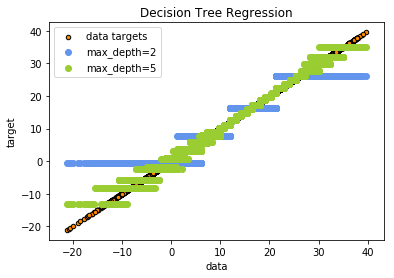

In [34]:
# Plot the results
plt.figure()
plt.scatter(y_test, y_test, s=20, edgecolor="black",
            c="darkorange", label="data targets")
plt.scatter(y_test, y_1, color="cornflowerblue",
         label="max_depth=2")
plt.scatter(y_test, y_2, color="yellowgreen", label="max_depth=5")
#plt.plot(y_test,y_test,c='g',label='actual')
plt.xlabel("data")
plt.ylabel("target")
plt.title("Decision Tree Regression")
plt.legend()
plt.show()